# Inference

## Stage 1: Load checkpoint and generate predictions. 

Store them with "truth" and metadata, so next stages have everything they need.

In [ ]:
# =============================================================================
checkpoint_file_path = "/iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/checkpoints/model.iter000010.pth"
output_dir = "/iopsstor/scratch/cscs/stefschu/DSM500/artifacts"

samples = 1
inference_rollout_steps = 5
# =============================================================================

import sys
sys.path.append('/iopsstor/scratch/cscs/stefschu/DSM500/github/modulus-a5275d8')

import torch
from modulus.utils_new.caching import Cache
from modulus.models_new.graphcast.graph_cast_net_newest import GraphCastNetNew
from modulus.datapipes.climate.era5_hdf5_newest import ERA5HDF5Datapipe
from modulus.distributed import DistributedManager
import numpy as np
from collections import defaultdict
import h5py
import json
from pathlib import Path
from hydra.utils import to_absolute_path

import hydra
with hydra.initialize(config_path=".", version_base="1.3"):
    cfg = hydra.compose(config_name="config_new")

DistributedManager.initialize()
dist = DistributedManager()
Cache.initialize(dir=cfg.cache_dir)


model = GraphCastNetNew(                    # Typical values
    sample_height=cfg.sample.height,        # 721
    sample_width=cfg.sample.width,          # 1440
    sample_channels=cfg.sample.channels,    # 21
    
    include_static_data=cfg.include.static_data,         # True
    include_spatial_info=cfg.include.spatial_info,       # True
    include_temporal_info=cfg.include.temporal_info,     # True
    include_solar_radiation=cfg.include.solar_radiation, # True

    batch_size=cfg.datapipe.batch_size,      # 1
    mesh_level=cfg.mesh_level,               # 6
    activation_fn=cfg.activation_fn,         # "silu",
    hidden_dim=cfg.hidden_dim,               # 512
    hidden_layers=cfg.hidden_layers,         # 1
    aggregation_op=cfg.aggregation_op,       # "sum"
    processor_layers=cfg.processor_layers,   # 16
)

model = model.to(dtype=torch.bfloat16).to(torch.device('cuda', index=0))

# Load checkpoint
checkpoint = torch.load(
    checkpoint_file_path,
    map_location=dist.device,
    weights_only=True
)
model.check_args(checkpoint["metadata"])
model.load_state_dict(checkpoint["model"])

# Configure the pipeline
datapipe = ERA5HDF5Datapipe(
    model=model,
    dataset_base_path=cfg.dataset.base_path,
    dataset_folder="out_of_sample",
    dataset_samples_per_file=cfg.dataset.samples_per_file,

    num_output_steps=inference_rollout_steps,

    iterator_seed=cfg.seed,
    iterator_offset_epoch_idx=0,
    iterator_offset_sample_idx=0,

    num_threads=1,
    prefetch_queue_depth=1
)

# Make sure the artifacts directory exists
output_dir = Path(to_absolute_path(output_dir))
output_dir.mkdir(parents=True, exist_ok=True)

# load means and stds
means = np.load(Path(to_absolute_path(cfg.dataset.base_path)) / "stats/global_means.npy")
stds = np.load(Path(to_absolute_path(cfg.dataset.base_path)) / "stats/global_stds.npy")

# Run inference
samples_container = defaultdict(list)
for sample_i, data in enumerate(datapipe):
    if sample_i >= samples:
        break

    input = data[0]["input"]
    truth = data[0]["output"]
    input_global_sample_id = data[0]["global_sample_id"]
    input_timestamps = data[0]["timestamps"]

    input_global_sample_id = input_global_sample_id
    input_timestamps = input_timestamps
    input = input.to(dtype=torch.bfloat16)
    truth = truth.to(dtype=torch.bfloat16)
    prediction = truth.clone()

    with torch.no_grad():
        next_input = input
        for step in range(inference_rollout_steps):
            _prediction = model(next_input)
            prediction[0, step, :21] = _prediction
            next_input = prediction[0, step]

    samples_container["global_sample_id"].append(input_global_sample_id.item())
    samples_container["timestamps"].append(input_timestamps[0].numpy())
    

    _input = input[0, :, :21].to(dtype=torch.float32).cpu().numpy() * stds + means
    _truth = truth[0, :, :21].to(dtype=torch.float32).cpu().numpy() * stds + means
    _prediction = prediction[0, :, :21].to(dtype=torch.float32).cpu().numpy() * stds + means
    
    samples_container["input"].append(_input)
    samples_container["truth"].append(_truth)
    samples_container["prediction"].append(_prediction)

    # The min and max ranges must be unified between truth and prediction so that visualized color can be compared
    samples_container["input_min"].append(_input.min(axis=(2, 3))) # (1, 21, 721, 1440) -> (1, 21)
    samples_container["input_max"].append(_input.max(axis=(2, 3))) # (1, 21, 721, 1440) -> (1, 21)
    _truth_prediction = np.concatenate([_prediction, _truth], axis=2) # (5, 21, 721, 1440) (5, 21, 721, 1440) -> (5, 21, 1442, 1440)
    samples_container["truth_prediction_min"].append(_truth_prediction.min(axis=(2, 3))) # (5, 21)
    samples_container["truth_prediction_max"].append(_truth_prediction.max(axis=(2, 3))) # (5, 21)

    print(f"Sample {sample_i+1} processed")

# Build activities index
activities_index = list()
for sample_i in range(samples):
    # Add input channels rendering
    for channel_i in range(cfg.input_channels):
        activities_index.append({
            "sample": sample_i,
            "channel": channel_i,
            "type": "input",
            "step": 0
        })
    # Rollout steps
    for step_i in range(inference_rollout_steps):
        # Prediction
        for channel_i in range(cfg.input_channels):
            activities_index.append({
                "sample": sample_i,
                "channel": channel_i,
                "type": "prediction",
                "step": step_i
            })
        # Truth
        for channel_i in range(cfg.input_channels):
            activities_index.append({
                "sample": sample_i,
                "channel": channel_i,
                "type": "truth",
                "step": step_i
            })

# Added filename
for i, a in enumerate(activities_index):
    activities_index[i] |= {"filename": f"sample{a['sample']:02}_{a['type']}_channel{a['channel']:02}_step{a['step']:02}.png"}

# Save samples container
with h5py.File(output_dir / "samples_container.h5", "w") as f:
    for key, value in samples_container.items():
        f.create_dataset(key, data=np.array(value))
    f.create_dataset("activities_index", data=json.dumps(activities_index))

/iopsstor/scratch/cscs/stefschu/DSM500/github/modulus-a5275d8/modulus/distributed/manager.py:346: UserWarning: Could not initialize using ENV, SLURM or OPENMPI methods. Assuming this is a single process job
  warn(


Sample 1 processed


Process SpawnProcess-1:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/nvidia/dali/_multiproc/worker.py", line 462, in worker
    scheduled, shm_chunk = worker_context.get_task()
  File "/usr/local/lib/python3.10/dist-packages/nvidia/dali/_multiproc/worker.py", line 434, in get_task
    scheduled_meta = self.task_receiver.get_task()
  File "/usr/local/lib/python3.10/dist-packages/nvidia/dali/_multiproc/worker.py", line 132, in get_task
    recv = self.queue.get()
  File "/usr/local/lib/python3.10/dist-packages/nvidia/dali/_multiproc/shared_queue.py", line 171, in get
    waited = self._wait_for_samples()
  File "/usr/local/lib/python3.10/dist-packages/nvidia/dali/_multiproc/shared_queue.py", line 99, in _wait_for_samples
    self.cv_not_e

## Stage 2: Images generation

In [ ]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import sys
from scipy.ndimage import sobel
import h5py
import os
from hydra.utils import to_absolute_path
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.transform import resize
from matplotlib.animation import FuncAnimation
import json

def fix_latitude_alignment(data: np.array):
    assert data.ndim == 2
    return np.concatenate((data[:, 720:], data[:, :720]), axis=1)

def load_edges(threshold = 0.5):
    with nc.Dataset("/iopsstor/scratch/cscs/stefschu/DSM500/data/FCN_ERA5_data_v0/static/land_sea_mask.nc", "r") as f:
        lsm = np.array(f["lsm"][0])
        edge_x = sobel(lsm, axis=0)
        edge_y = sobel(lsm, axis=1)
        edges = np.hypot(edge_x, edge_y)
        edges = edges / edges.max()
        
        edges[edges > threshold] = 1.
        edges[edges <= threshold] = 0.

        # Fix longitutes alignment, to match that coming out of the model itself
        edges = fix_latitude_alignment(edges)
        return edges

def plot_on_globe(image_2d, vmin, vmax, edges, resolution_reduction_factor=1.0, edge_intensity=1.):
    ###### image preprocessing ######
    # Reduce image resolution (to speed up rendering during development)
    new_size = (image_2d.shape[0]//resolution_reduction_factor, image_2d.shape[1]//resolution_reduction_factor)
    image_2d = resize(image_2d, new_size, anti_aliasing=True)
    edges = resize(edges, new_size, anti_aliasing=True)

    # Flip image upside down
    image_2d = np.flipud(image_2d)
    edges = np.flipud(edges)

    # Make RGB
    image_2d = (image_2d - vmin) / (vmax - vmin)
    cmap = plt.get_cmap("viridis") # alternative: "RdBu_r"
    image_rgb = cmap(image_2d)[..., :3] # Remove the alpha channel

    # Blend in edges
    image_rgb = image_rgb * (1 - edge_intensity * edges[..., None])
    

    ###### prepare 3D sphere ######
    # Prepare coordinates for the spheric shape
    latitudes, longitudes = image_2d.shape[:2]
    # Spherical coordinates
    phi = np.linspace(-np.pi/2, np.pi/2, latitudes)
    theta = np.linspace(-np.pi, np.pi, longitudes)
    phi, theta = np.meshgrid(phi, theta, indexing="ij")
    # Cartesian coordinates
    x = np.cos(phi) * np.cos(theta)
    y = np.cos(phi) * np.sin(theta)
    z = np.sin(phi)


    ###### plot ######
    # Create figure and 3D axis
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    
    # Plot the surface
    ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=image_rgb, shade=False, antialiased=True)
    #plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin, vmax)), ax=ax)

    # Make background panes transparent
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False

    ax.grid(False)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    
    ax.view_init(elev=30, azim=45)

    plt.axis('off')
    ax.set_proj_type('persp')
    plt.tight_layout()
    
    #plt.colorbar(im)

edges = load_edges()

# Load activities for this rank
with h5py.File("samples_container.h5", "r") as samples_file:
    activities_index = json.loads(samples_file["activities_index"][()])

    world_size = os.environ.get("WORLD_SIZE", 1)
    rank = os.environ.get("RANK", 0)

    activities_for_this_rank = np.array_split(activities_index, world_size)[rank]
    
    # For each activity, generate the image
    for activity_i, activity in enumerate(activities_for_this_rank):
        filename = activity["filename"]

        filepath = Path(to_absolute_path(filename))
        if filepath.exists():
            continue

        print(f"Processing activity for file {filepath} ...")

        # Extract data of interest
        sample = activity["sample"]
        type = activity["type"]
        channel = activity["channel"]
        step = activity["step"]
        
        # Extract metadata
        global_sample_id = samples_file["global_sample_id"][sample]
        timestamps = samples_file["timestamps"][sample]

        if type == "input":
            image_2d = samples_file["input"][sample][step][channel] # For the input there is only step 0
            vmin = samples_file["input_min"][sample][step][channel]
            vmax = samples_file["input_max"][sample][step][channel]
        elif type == "prediction":
            image_2d = samples_file["prediction"][sample][step][channel]
            vmin = samples_file["truth_prediction_min"][sample][step][channel]
            vmax = samples_file["truth_prediction_max"][sample][step][channel]
        elif type == "truth":
            image_2d = samples_file["truth"][sample][step][channel]
            vmin = samples_file["truth_prediction_min"][sample][step][channel] # Fix: remove code duplication
            vmax = samples_file["truth_prediction_max"][sample][step][channel]

        plot_on_globe(image_2d, vmin=vmin, vmax=vmax, edges=edges, resolution_reduction_factor=10)
        #plt.show()
        plt.savefig(filepath, dpi=300, bbox_inches='tight', transparent=True, pad_inches=-1.2)
        plt.close()

        if activity_i > 5:
            break

Processing activity for file /iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/sample00_input_channel00_step00.png ...
Rendering /iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/sample00_input_channel00_step00.png...
Processing activity for file /iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/sample00_input_channel01_step00.png ...
Rendering /iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/sample00_input_channel01_step00.png...
Processing activity for file /iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/sample00_input_channel02_step00.png ...
Rendering /iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/sample00_input_channel02_step00.png...
Processing activity for file /iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/sample00_input_channel03_step00.png ...
Rendering /iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/sample00_input_channel03_step00.png...
Processing activity for file /iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/samp

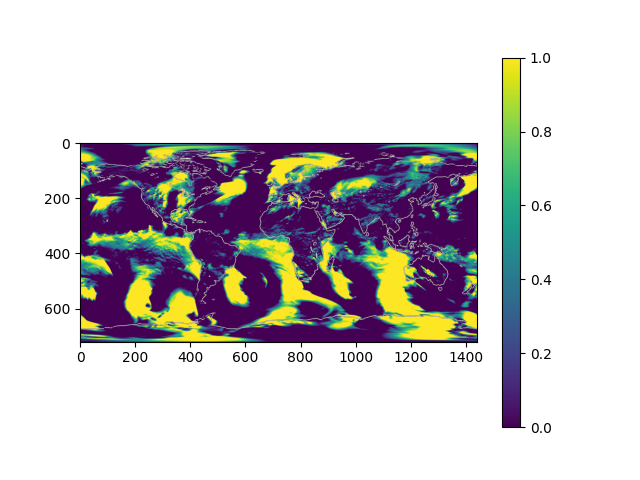

In [29]:
plt.figure()
im = plt.imshow(image_data)
plt.colorbar(im)
plt.show()

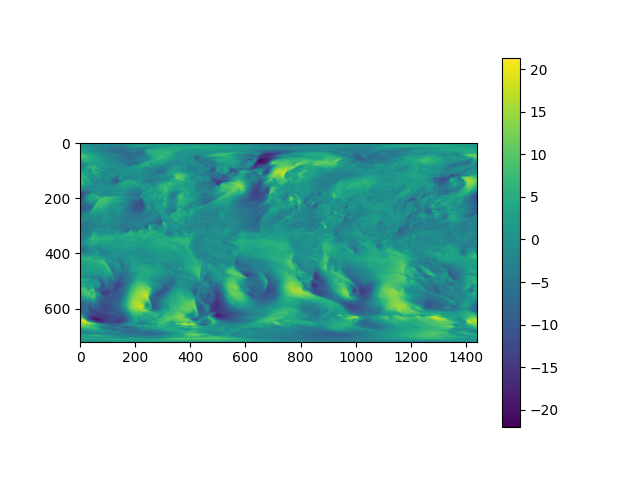

In [30]:
with h5py.File("/iopsstor/scratch/cscs/stefschu/DSM500/data/FCN_ERA5_data_v0/out_of_sample/2018.h5", "r") as f:
    _image = f["fields"][global_sample_id][channel]
    _image = fix_latitude_alignment(_image)
    plt.figure()
    im = plt.imshow(_image)
    plt.colorbar(im)
    plt.show()

0
1
2
3


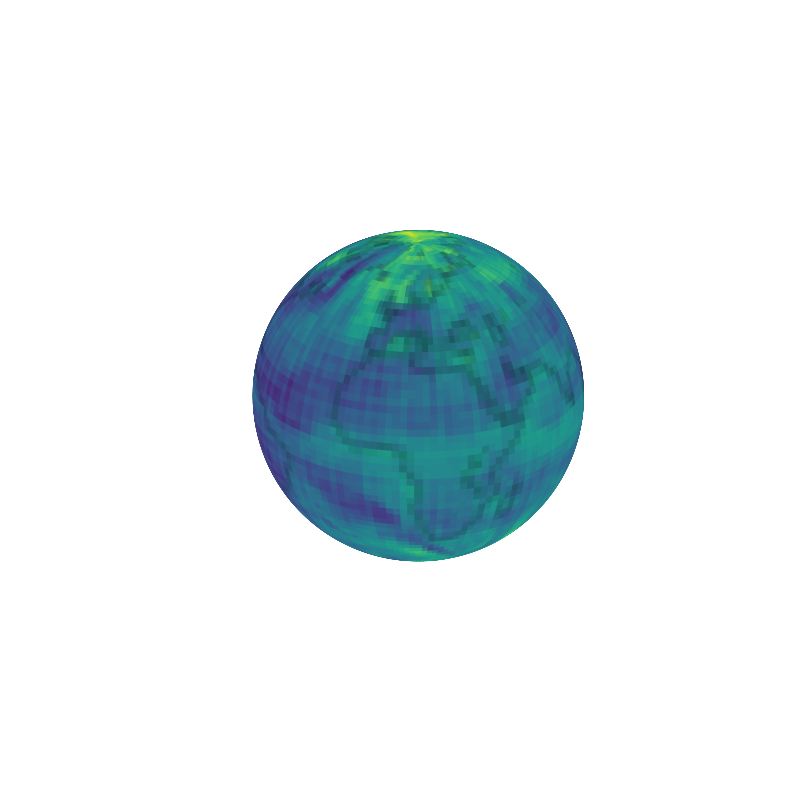

In [11]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.transform import resize
from matplotlib.animation import FuncAnimation

def plot_globe(texture_img, point=None, scale=1.0):
    img = texture_img

    # Reduce image resolution
    img = resize(img, (img.shape[0]//scale, img.shape[1]//scale), anti_aliasing=True)

    # Normalize
    # img = (img - img.min()) / (img.max() - img.min())

    # Make it RGB but make it look like 
    # cmap = plt.get_cmap("RdBu_r") #coolwarm") #"Spectral") #"coolwarm")#"viridis")
    # img = cmap(img)[:, :, :3]

    # Flip image upside down
    img = np.flipud(img)

    # Image dimensions
    latitudes, longitudes = img.shape[:2]

    # Generate correct sphere mesh grid
    phi = np.linspace(-np.pi/2, np.pi/2, latitudes)
    theta = np.linspace(-np.pi, np.pi, longitudes)
    phi, theta = np.meshgrid(phi, theta, indexing="ij")

    # Convert spherical coordinates to Cartesian
    r = 1
    x = r * np.cos(phi) * np.cos(theta)
    y = r * np.cos(phi) * np.sin(theta)
    z = r * np.sin(phi)

    # Create figure and 3D axis
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=img[:, :, :3], shade=False)

    # Make panes transparent
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False

    ax.grid(False)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))  # Transparent X pane
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))  # Transparent Y pane
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))  # Transparent Z pane
    
    # Remove the axis
    plt.axis('off')
    ax.set_proj_type('persp')  # Enable perspective projection

    #plt.savefig("sphere.png", dpi=300, bbox_inches='tight', transparent=True, pad_inches=-1.2)

    # def update(angle):
    #     ax.view_init(elev=30 + angle/20, azim=angle)

    # ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 2), interval=50)
    
    # Rotate the plot
    i = 0
    for azim in range(0, 20, 5):
        ax.view_init(elev=25, azim=azim)
        plt.savefig(f"sphere_{i:04d}.png", dpi=300, bbox_inches='tight', transparent=True, pad_inches=-1.2)
        print(i)
        i += 1

    #plt.show()

plot_globe(texture_img=img, scale=10.0)

## Stage 3: Video building

In [1]:
import cv2
print(cv2.__version__)

4.11.0


In [91]:
import h5py
import json
from datetime import datetime

def get_filename(activities, type, sample, channel, step):
    for a in activities:
        if a["type"] == type and a["sample"] == sample and a["channel"] == channel and a["step"] == step:
            return a["filename"]
    raise ValueError(f"Activity not found for type={type}, sample={sample}, channel={channel}, step={step}")

with h5py.File("/iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/_inference/artifacts/inference_samples_container.h5", "r") as f:
    print(f.keys())
    activities = json.loads(f["activities"][()])
    samples, rollout_steps, channels, _, _ = f["prediction"].shape
    for sample in range(samples):
        sample_timestamps = list(map(lambda ts: str(datetime.fromtimestamp(ts)), f["timestamps"][sample]))
        sample_global_id = f["global_sample_id"][sample]

        for channel in range(channels):
            # Render the input
            filename_input = get_filename(activities, "input", sample, channel, 0)
            vmin, vmax = f["input_min"][sample, 0, channel], f["input_max"][sample, 0, channel]
            
            for step in range(rollout_steps):
                filename_truth = get_filename(activities, "truth", sample, channel, step)
                filename_prediction = get_filename(activities, "prediction", sample, channel, step)
                vmin, vmax = f["truth_prediction_min"][sample, step, channel], f["truth_prediction_max"][sample, step, channel]
                

<KeysViewHDF5 ['activities', 'global_sample_id', 'input', 'input_max', 'input_min', 'prediction', 'timestamps', 'truth', 'truth_prediction_max', 'truth_prediction_min']>


In [ ]:
import cv2
import glob
from pathlib import Path

base_path = Path("/iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/_inference/artifacts")
pattern = "images/sample01_prediction_channel00_step*.png"

image_files = sorted(base_path.glob(pattern))

# Read the first image to get dimensions
frame = cv2.imread(image_files[0])
h, w, _ = frame.shape

# Define the video writer
video_filename = base_path / "output.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Codec for MP4
fps = 0.2  # Adjust frames per second
out = cv2.VideoWriter(video_filename, fourcc, fps, (w, h))

# Write images to video
for img in image_files:
    frame = cv2.imread(img)
    out.write(frame)

# Release the video writer
out.release()

print(f"Video saved as {video_filename}")

Video saved as /iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/_inference/artifacts/output.mp4


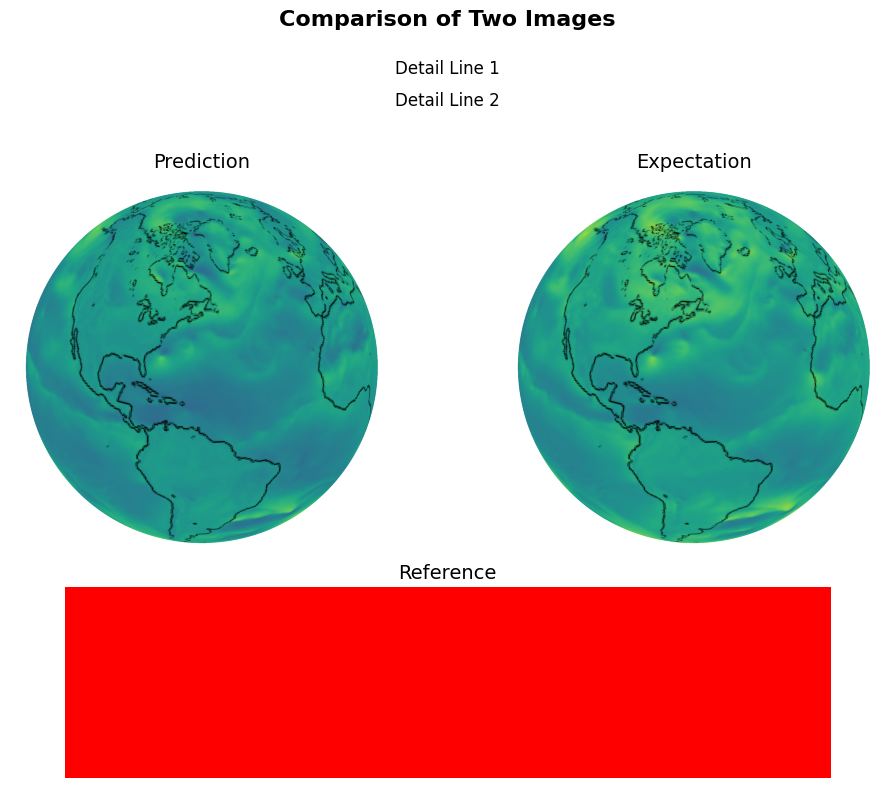

In [65]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from matplotlib.gridspec import GridSpec

def crop_image(image, l=150, r=90, t=90, b=150):
    h, w, _ = image.shape
    return image[t:h-b, l:w-r]

img1 = crop_image(mpimg.imread(image_files[0]))
img2 = crop_image(mpimg.imread(image_files[1]))

# Generate a fully red image for the third image
def generate_red_image(width, height):
    return np.full((height, width, 3), [255, 0, 0], dtype=np.uint8)

img3 = generate_red_image(800, 200)  # Adjust size as needed

fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2, 2, height_ratios=[1, 0.5])

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])  # This spans both columns

# Display top row images
ax1.imshow(img1)
ax1.set_title("Prediction", fontsize=14)
ax2.imshow(img2)
ax2.set_title("Expectation", fontsize=14)

# Display bottom row image spanning both columns
ax3.imshow(img3)
ax3.set_title("Reference", fontsize=14)

# Remove axis ticks
for ax in [ax1, ax2, ax3]:
    ax.axis("off")

fig.suptitle("Comparison of Two Images", fontsize=16, fontweight="bold")
# Add additional detail lines (not bold)
fig.text(0.5, 0.90, "Detail Line 1", ha='center', fontsize=12)
fig.text(0.5, 0.86, "Detail Line 2", ha='center', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.show()


In [102]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from matplotlib.gridspec import GridSpec

import cv2
import glob
from pathlib import Path
from io import BytesIO

def generate_temp_frame(file_path, title, subtitle_1, subtitle_2, image_file_path_left, image_file_path_right, title_left, title_right):
    def crop_image(image, l=150, r=90, t=90, b=150):
        h, w, _ = image.shape
        return image[t:h-b, l:w-r]

    image_left = crop_image(mpimg.imread(image_file_path_left))
    image_right = crop_image(mpimg.imread(image_file_path_right))

    # Generate a fully red image for the third image
    def generate_red_image(width, height):
        return np.full((height, width, 3), [255, 0, 0], dtype=np.uint8)

    img3 = generate_red_image(800, 200)  # Adjust size as needed

    fig = plt.figure(figsize=(10, 8))
    gs = GridSpec(2, 2, height_ratios=[1, 0.5])

    # Create subplots
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])  # This spans both columns

    # Image left
    ax1.imshow(image_left)
    ax1.set_title(title_left, fontsize=14)

    # Image right
    ax2.imshow(image_right)
    ax2.set_title(title_right, fontsize=14)

    # Display bottom row image spanning both columns
    ax3.imshow(img3)
    ax3.set_title("Reference", fontsize=14)

    # Remove axis ticks
    for ax in [ax1, ax2, ax3]:
        ax.axis("off")

    fig.suptitle(title, fontsize=16, fontweight="bold")
    # Add additional detail lines (not bold)
    fig.text(0.5, 0.90, subtitle_1, ha='center', fontsize=12)
    fig.text(0.5, 0.86, subtitle_2, ha='center', fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.85])

    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.close(fig)

class VideoGenerator:
    def __init__(self, output_file_path, fps=5):
        self.out = None
        self.output_file_path = output_file_path
        self.fps = fps
        

    def add_image(self, file_path):
        frame = cv2.imread(file_path)

        if self.out is None:
            height, width, _ = frame.shape
            fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Codec for MP4
            self.out = cv2.VideoWriter(self.output_file_path, fourcc, self.fps, (width, height))

        self.out.write(frame)

    def close(self):
        self.out.release()

import h5py
import json
from datetime import datetime

def get_filename(activities, type, sample, channel, step):
    for a in activities:
        if a["type"] == type and a["sample"] == sample and a["channel"] == channel and a["step"] == step:
            return a["filename"]
    raise ValueError(f"Activity not found for type={type}, sample={sample}, channel={channel}, step={step}")

with h5py.File("/iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/_inference/artifacts/inference_samples_container.h5", "r") as f:
    activities = json.loads(f["activities"][()])
    samples, rollout_steps, channels, height, width = f["prediction"].shape

    video_generator = VideoGenerator("/iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/_inference/artifacts/output.mp4")

    for channel in range(channels):
        print(f"Starting channel {channel+1} ...")

        for sample in range(samples):
            print(f"\tStarting sample {sample+1} ...")
            sample_timestamps = list(map(lambda ts: str(datetime.fromtimestamp(ts)), f["timestamps"][sample]))
            sample_global_id = f["global_sample_id"][sample]

            # Render the input
            filename_input = get_filename(activities, "input", sample, channel, 0)
            filename_input = f"/iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/_inference/artifacts/images/{filename_input}"
            vmin, vmax = f["input_min"][sample, 0, channel], f["input_max"][sample, 0, channel]

            generate_temp_frame(
                file_path="/iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/_inference/artifacts/images/temp.png",
                title="Sample 01",
                subtitle_1="Prediction vs Expectation",
                subtitle_2="Comparison of two images",
                image_file_path_left=filename_input,
                image_file_path_right=filename_input,
                title_left="Prediction",
                title_right="Expectation"
            )
            video_generator.add_image("/iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/_inference/artifacts/images/temp.png")
            
            for step in range(rollout_steps):
                print(f"\t\tStarting step {step+1} ...")

                filename_truth = get_filename(activities, "truth", sample, channel, step)
                filename_truth = f"/iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/_inference/artifacts/images/{filename_truth}"
                filename_prediction = get_filename(activities, "prediction", sample, channel, step)
                filename_prediction = f"/iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/_inference/artifacts/images/{filename_prediction}"
                vmin, vmax = f["truth_prediction_min"][sample, step, channel], f["truth_prediction_max"][sample, step, channel]

                import time
                t0 = time.time()
                generate_temp_frame(
                    file_path="/iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/_inference/artifacts/images/temp.png",
                    title="Sample 01",
                    subtitle_1="Prediction vs Expectation",
                    subtitle_2="Comparison of two images",
                    image_file_path_left=filename_prediction,
                    image_file_path_right=filename_truth,
                    title_left="Prediction",
                    title_right="Expectation"
                )
                print(f"\t\t\tTime taken to generate image: {time.time() - t0:.2f} seconds")
                t1 = time.time()
                video_generator.add_image("/iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/_inference/artifacts/images/temp.png")
                print(f"\t\t\tTime taken to add image to video: {time.time() - t1:.2f} seconds")

        if channel > 2:
            break

    video_generator.close()
    print("Video saved")

Starting channel 1 ...
	Starting sample 1 ...
		Starting step 1 ...
			Time taken to generate image: 1.03 seconds
			Time taken to add image to video: 0.11 seconds
		Starting step 2 ...
			Time taken to generate image: 1.09 seconds
			Time taken to add image to video: 0.10 seconds
		Starting step 3 ...
			Time taken to generate image: 1.06 seconds
			Time taken to add image to video: 0.11 seconds
		Starting step 4 ...
			Time taken to generate image: 1.07 seconds
			Time taken to add image to video: 0.11 seconds
		Starting step 5 ...
			Time taken to generate image: 1.23 seconds
			Time taken to add image to video: 0.11 seconds
		Starting step 6 ...
			Time taken to generate image: 1.05 seconds
			Time taken to add image to video: 0.11 seconds
		Starting step 7 ...
			Time taken to generate image: 1.03 seconds
			Time taken to add image to video: 0.11 seconds
		Starting step 8 ...
			Time taken to generate image: 1.05 seconds
			Time taken to add image to video: 0.11 seconds
	Starting 

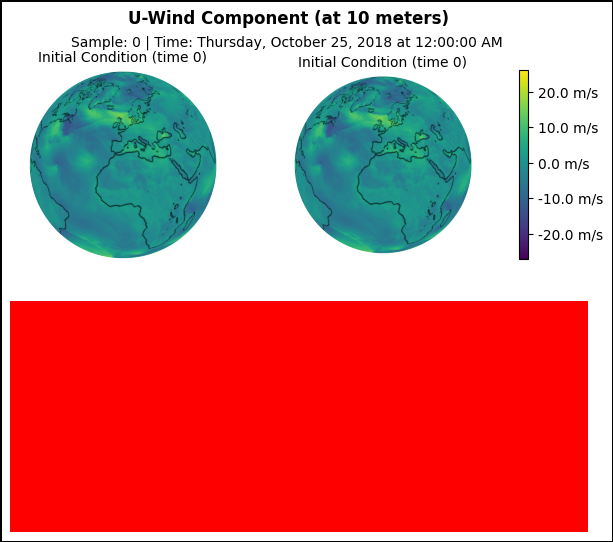

In [55]:
import sys
sys.path.append('/iopsstor/scratch/cscs/stefschu/DSM500/github/modulus-a5275d8')

import numpy as np
import json
import h5py
import hydra
from omegaconf import DictConfig

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.ticker as ticker
from datetime import datetime

import numpy as np

from modulus.launch.logging import PythonLogger

# FIXIT: Move it under modulus
from inference import Inference


def generate_video_frame(
    input_file_path_left,
    input_file_path_right,
    output_file_path, 
    vmin,
    vmax,
    title,
    subtitle,
    title_left,
    title_right,
    ticks_format
):
    def crop_image(image, l=105, r=60, t=60, b=115):
        h, w, _ = image.shape
        return image[t:h-b, l:w-r]

    # Create figure, with a border
    fig = plt.figure(figsize=(8, 6), dpi=100)
    fig.patch.set_edgecolor('black')
    fig.patch.set_linewidth(1)

    gs = GridSpec(
        2, 3,
        width_ratios=[1, 1, 0.05],  # Two equal columns + narrow color bar column
        height_ratios=[0.45, 0.55]
    )

    # Create subplots
    ax_til = fig.add_subplot(gs[0, 0]) # first row, top image left
    ax_tir = fig.add_subplot(gs[0, 1]) # first row, top image right
    ax_b = fig.add_subplot(gs[1, :]) # bottom row (collapsed in a single cell)

    # Title and subtitles
    fig.suptitle(title, fontsize=12, fontweight="bold")
    fig.text(0.5, 0.92, subtitle, ha='center', fontsize=10)

    # Image top left
    image_left = crop_image(mpimg.imread(input_file_path_left))
    ax_til.imshow(image_left)
    ax_til.set_title(title_left, fontsize=10)

    # Image top right
    image_right = crop_image(mpimg.imread(input_file_path_right))
    ax_tir.imshow(image_right)
    ax_tir.set_title(title_right, fontsize=10)

    # Color bar
    cbar = plt.colorbar(cm.ScalarMappable(
        norm=plt.Normalize(vmin, vmax),
        cmap=plt.get_cmap("viridis")
    ), ax=ax_tir, pad=0.17)
    cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: ticks_format.format(x)))

    # Display bottom row image spanning both columns
    # FIXME: Remove this once the line plot is ready
    def generate_red_image(width, height):
        return np.full((height, width, 3), [255, 0, 0], dtype=np.uint8)
    _temp = generate_red_image(1000, 400)
    ax_b.imshow(_temp)

    # Remove axis ticks
    for ax in [ax_til, ax_tir, ax_b]:
        ax.axis("off")

    #plt.subplots_adjust(left=0.05, right=0.92, top=0.90, bottom=0.05)
    #plt.subplots_adjust()
    #plt.tight_layout(rect=[0, 0, 1, 0.95])
    #plt.savefig(output_file_path, bbox_inches='tight')
    #plt.savefig(output_file_path, dpi=200, pad_inches=0)
    plt.show()
    plt.close(fig)

import hydra
with hydra.initialize(
    config_path="..",
    version_base="1.3"
):
    cfg = hydra.compose(config_name="config_new")

logger = PythonLogger("main")
logger.file_logging()

inference = Inference(cfg, logger)

# Load plan, and select activities for this rank
with open(inference.plan_file_path, "r") as f:
    plan = json.load(f)
# Filter out pause frames which do not need to be rendered
activities = [a for a in plan if a["type"] != "pause"]
activities_for_this_rank = np.array_split(activities, inference.world_size)[inference.rank]
logger.info(f"[Rank {inference.rank}] Loaded {len(activities_for_this_rank)} activities for this rank")

# For each activity, generate the image
with h5py.File(inference.container_file_path, "r") as f:
    for activity_i, activity in enumerate(activities_for_this_rank):
        output_file_path = inference.images_dir / f"frame_{activity['frame_id']}.png"

        if output_file_path.exists():
            logger.info(f"[Rank {inference.rank}] File {output_file_path} already exists. Skipping.")
            #continue
        else:
            logger.info(f"[Rank {inference.rank}] Generating {output_file_path}...")

        if activity["type"] == "ic":
            input_file_path_left = input_file_path_right = inference.images_dir / activity["filename"]
            title_left = title_right = "Initial Condition (time 0)"
        else:
            input_file_path_left = inference.images_dir / activity["filename"]["reanalysis"]
            input_file_path_right = inference.images_dir / activity["filename"]["forecast"]
            step = activity["step"]
            title_left = f"Reanalysis (time +{step+1})"
            title_right = f"Forecast (time +{step+1})"

        title = inference.get_channel_title(activity["channel"])
        sample = activity["sample"]
        timestamp = datetime.fromtimestamp(activity["timestamp"])
        time_string = timestamp.strftime("%A, %B %d, %Y at %I:%M:%S %p %Z")
        subtitle = f"Sample: {sample} | Time: {time_string}"

        generate_video_frame(
            title=title,
            subtitle=subtitle,
            
            title_left=title_left,
            input_file_path_left=input_file_path_left,

            title_right=title_right,
            input_file_path_right=input_file_path_right,

            vmin=activity["vmin"],
            vmax=activity["vmax"],
            ticks_format=inference.get_channel_tick_format(activity["channel"]),
                            
            output_file_path=output_file_path,
        )

        logger.info(f"[Rank {inference.rank}] File {output_file_path} created. {len(activities_for_this_rank) - activity_i - 1} activities left.")       
        break

In [63]:
globe_image = "/iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/_inference/artifacts/images/channel00_sample00_ic.png"
vmin = 0
vmax = 0
ticks_format = "{:.1f} K"
def crop_image(image, l=105, r=60, t=60, b=115):
    h, w, _ = image.shape
    return image[t:h-b, l:w-r]


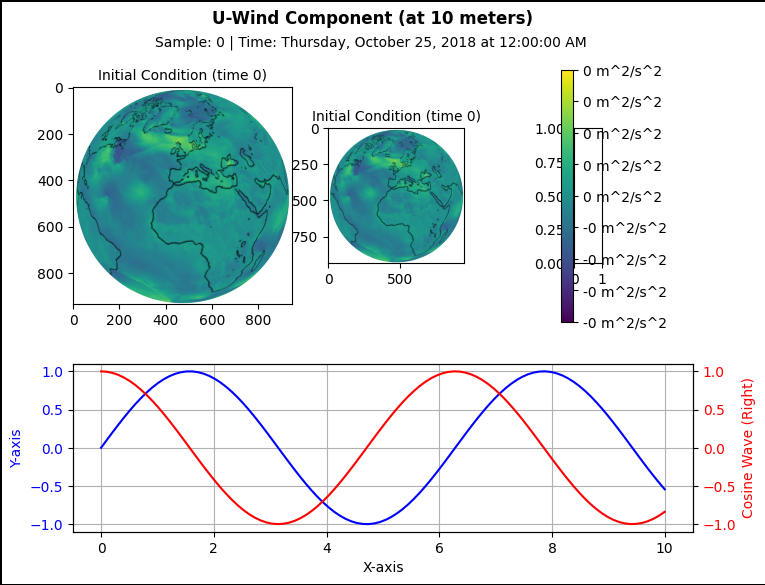

In [115]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(8, 6), dpi=100)
fig.patch.set_edgecolor('black')
fig.patch.set_linewidth(1)

gs = GridSpec(
    2, 3,
    width_ratios=[0.4, 0.5, 0.1],  # Two equal columns + narrow color bar column
    height_ratios=[0.6, 0.4]
)

# Create subplots
ax_til = fig.add_subplot(gs[0, 0]) # first row, top image left
ax_tir = fig.add_subplot(gs[0, 1]) # first row, top image right
ax_b = fig.add_subplot(gs[1, :]) # bottom row (collapsed in a single cell)

# Title and subtitles
fig.suptitle(title, fontsize=12, fontweight="bold")
fig.text(0.5, 0.92, subtitle, ha='center', fontsize=10)
# Image top left
ax_til.imshow(crop_image(mpimg.imread(globe_image)))
ax_til.set_title(title_left, fontsize=10)
# Image top right
ax_tir.imshow(crop_image(mpimg.imread(globe_image)))
ax_tir.set_title(title_right, fontsize=10)

divider = make_axes_locatable(ax_tir)
cax = divider.append_axes("right", size="20%", pad=1.1)

# Color bar
cbar = plt.colorbar(cm.ScalarMappable(
    norm=plt.Normalize(vmin, vmax),
    cmap=plt.get_cmap("viridis")
), ax=cax)
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: "{:.0f} m^2/s^2".format(x)))

# FIXME: Display bottom row image spanning both columns
x = np.linspace(0, 10, 100)
y_sin = np.sin(x)
y_cos = np.cos(x)
ax_b.plot(x, y_sin, label='Sine Wave', color='blue')
#ax_b.set_title("Matplotlib Line Chart on Existing axis")
ax_b.set_xlabel("X-axis")
ax_b.set_ylabel("Y-axis", color='blue')
ax_b.tick_params(axis='y', labelcolor='blue')
ax_b.grid(True)

ax_right = ax_b.twinx()
ax_right.plot(x, y_cos, label='Cosine Wave', color='red')
ax_right.set_ylabel('Cosine Wave (Right)', color='red')
ax_right.tick_params(axis='y', labelcolor='red')

# Remove axis ticks
for ax in [ax_til, ax_tir]:
    #ax.axis("off")
    pass

plt.show()

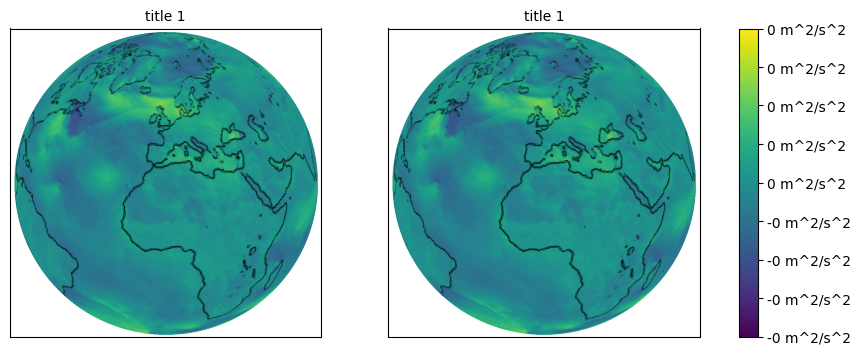

In [166]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Sample data
data1 = np.random.rand(10, 10)
data2 = np.random.rand(10, 10)

fig = plt.figure(figsize=(10, 4))
# Define a grid with 1 row and 3 columns; the colorbar gets a narrower width
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.05)

# Create axes for each image and the colorbar
ax1 = fig.add_subplot(gs[0])
ax1.set_title("title 1", fontsize=10)
ax2 = fig.add_subplot(gs[1])
ax2.set_title("title 1", fontsize=10)
cax = fig.add_subplot(gs[2])

# Plot the images
im1 = ax1.imshow(crop_image(mpimg.imread(globe_image)), aspect='equal')
im2 = ax2.imshow(crop_image(mpimg.imread(globe_image)), aspect='equal')

# Optionally remove ticks for clarity
for ax in (ax1, ax2):
    ax.set_xticks([])
    ax.set_yticks([])

# Create a colorbar on the third axis using one of the images
cbar = fig.colorbar(cm.ScalarMappable(
    norm=plt.Normalize(vmin, vmax),
    cmap=plt.get_cmap("viridis")
), cax=cax)
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: "{:.0f} m^2/s^2".format(x)))

plt.show()


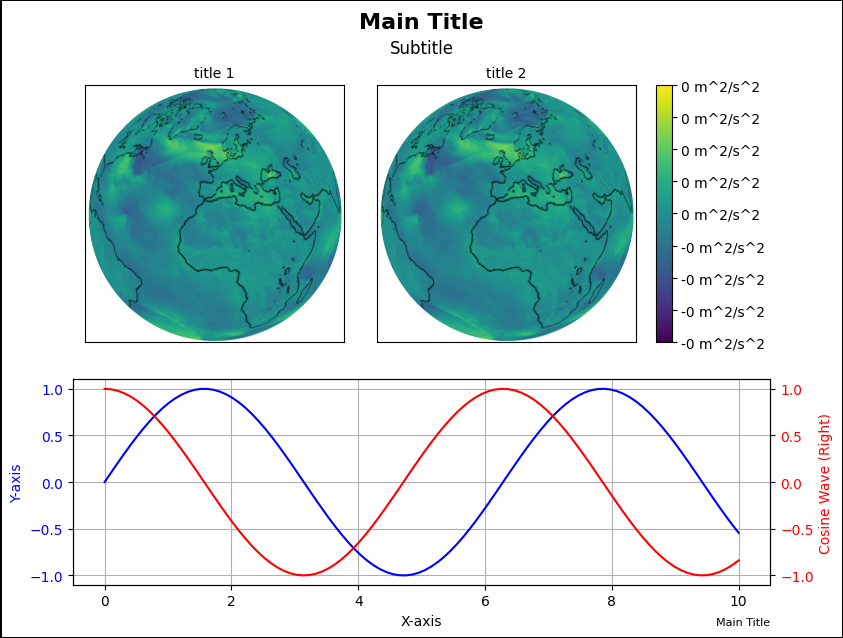

In [213]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Sample data
rect_data = np.random.rand(6, 20)  # Rectangular image

fig = plt.figure(figsize=(9, 8))
fig.patch.set_edgecolor('black')
fig.patch.set_linewidth(1)


# 3 rows, 3 columns: top (title row), middle (two images + colorbar), bottom (rect image).
gs = gridspec.GridSpec(
    4, 4,
    height_ratios=[0.15, 1, 0.8, 0.01],
    width_ratios=[0.94, 0.94, 0.05, 0.3],
    hspace=0.3, wspace=0.05
)

# Title/subtitle in the top row
ax_title = fig.add_subplot(gs[0, :])
ax_title.axis('off')
ax_title.text(0.5, 0.5, "Main Title", fontsize=16, fontweight='bold',
              ha='center', transform=ax_title.transAxes)
ax_title.text(0.5, -0.15, "Subtitle", fontsize=12, ha='center',
              transform=ax_title.transAxes)

# Middle row: two images + colorbar
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])
cax = fig.add_subplot(gs[1, 2])

ax1.set_title("title 1", fontsize=10)
ax2.set_title("title 2", fontsize=10)

im1 = ax1.imshow(crop_image(mpimg.imread(globe_image)), aspect='equal')
im2 = ax2.imshow(crop_image(mpimg.imread(globe_image)), aspect='equal')
for ax in (ax1, ax2):
    ax.set_xticks([])
    ax.set_yticks([])

cbar = fig.colorbar(cm.ScalarMappable(
    norm=plt.Normalize(vmin, vmax),
    cmap=plt.get_cmap("viridis")
), cax=cax)
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: "{:.0f} m^2/s^2".format(x)))


# Bottom row: rectangular image limited to columns [0:2]
# so it aligns with the left edges of the two images above
ax_rect = fig.add_subplot(gs[2, :])
# ax_rect.imshow(rect_data)
# ax_rect.set_xticks([])
# ax_rect.set_yticks([])

x = np.linspace(0, 10, 100)
y_sin = np.sin(x)
y_cos = np.cos(x)
ax_rect.plot(x, y_sin, label='Sine Wave', color='blue')
#ax_b.set_title("Matplotlib Line Chart on Existing axis")
ax_rect.set_xlabel("X-axis")
ax_rect.set_ylabel("Y-axis", color='blue')
ax_rect.tick_params(axis='y', labelcolor='blue')
ax_rect.grid(True)

ax_right = ax_rect.twinx()
ax_right.plot(x, y_cos, label='Cosine Wave', color='red')
ax_right.set_ylabel('Cosine Wave (Right)', color='red')
ax_right.tick_params(axis='y', labelcolor='red')







ax_footer = fig.add_subplot(gs[3, :])
ax_footer.axis('off')
ax_footer.text(1, 0.0, "Main Title", fontsize=8, ha='right', transform=ax_footer.transAxes)

plt.show()


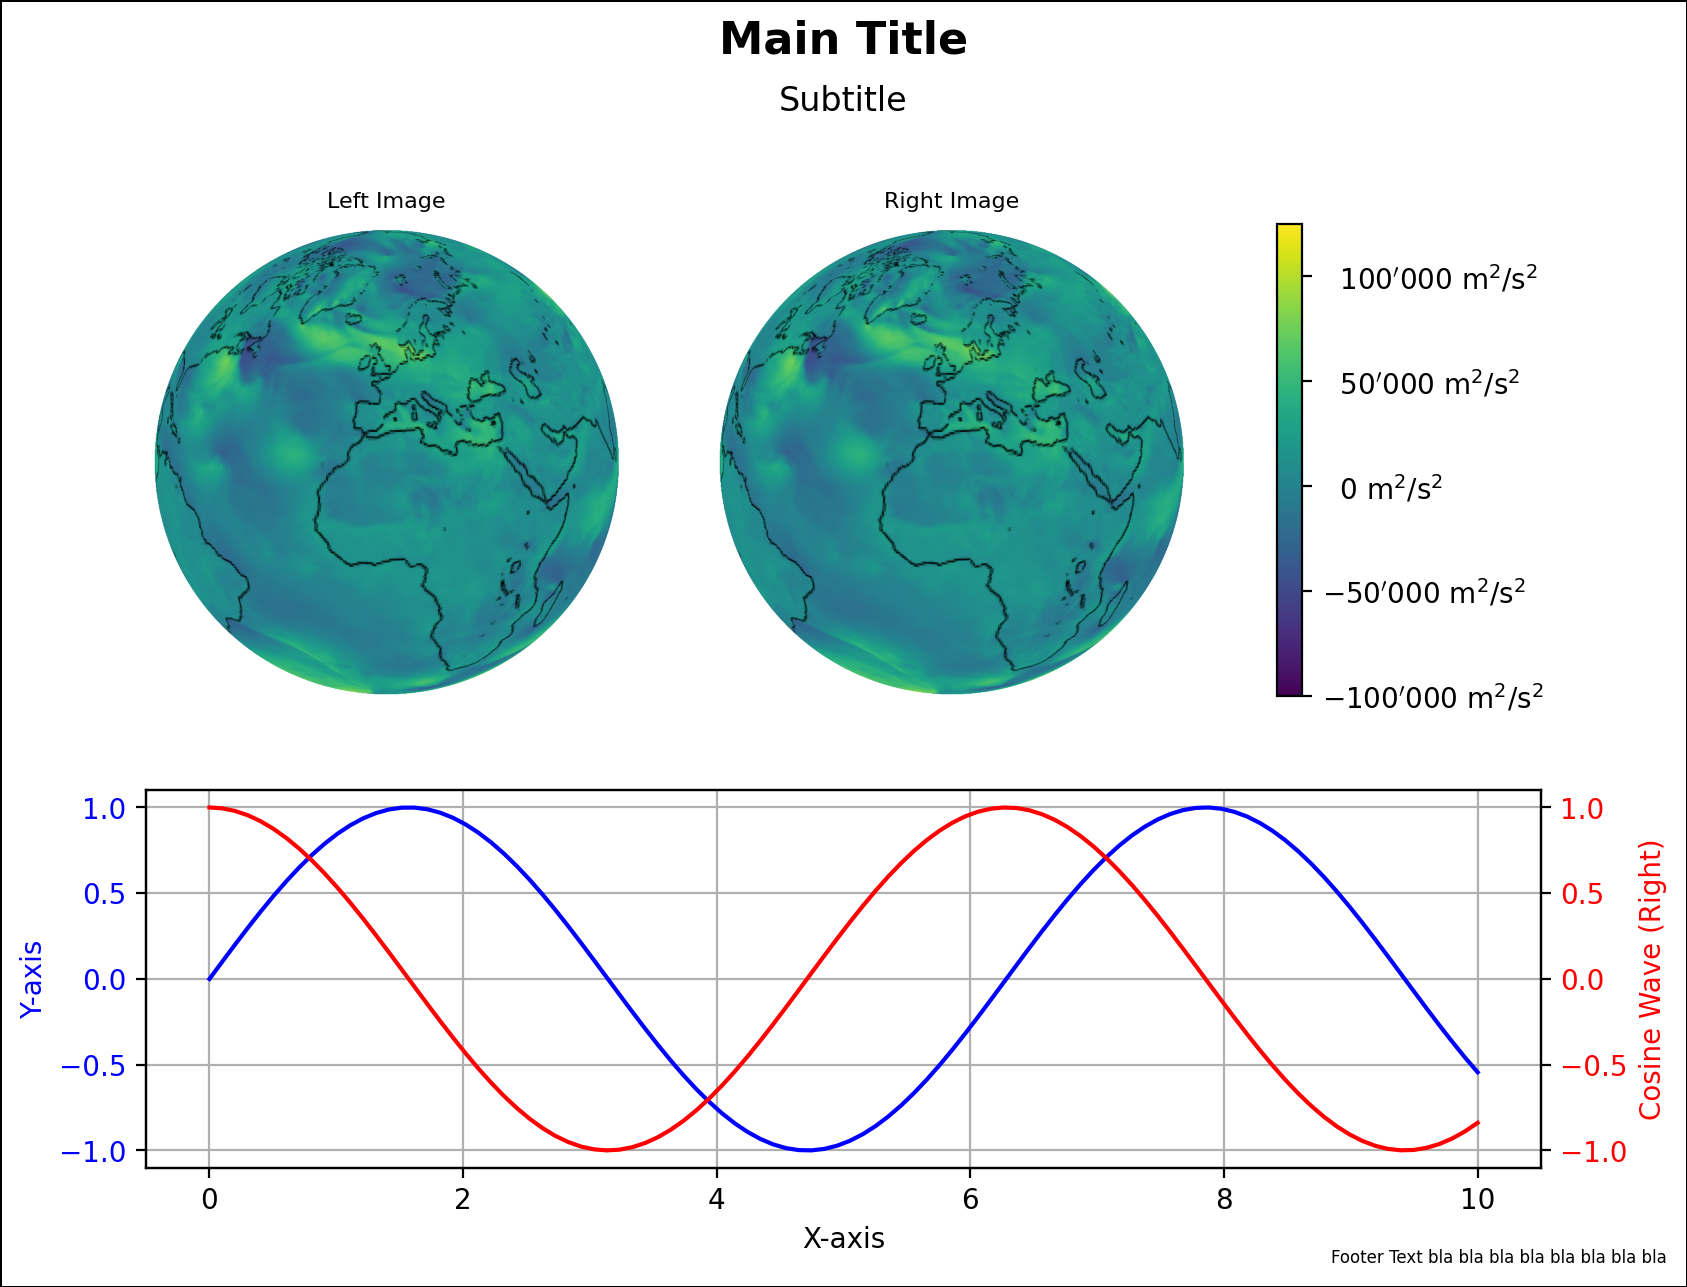

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import numpy as np

class VideoFrameTwoGlobes:
    def __init__(
        self,
        dpi=200,
        crop=(105, 60, 60, 115) # l, r, t, b
    ):
        self.crop = crop
        self.dpi = dpi

        self.fig = plt.figure(figsize=(9, 8), dpi=self.dpi)
        self.fig.patch.set_edgecolor('black')
        self.fig.patch.set_linewidth(1)

        gs = GridSpec(
            4, 4,
            height_ratios=[0.2, 1, 0.8, 0.01],
            width_ratios=[0.94, 0.94, 0.05, 0.3],
            hspace=0.4, wspace=0.3
        )

        self.ax_title = self.fig.add_subplot(gs[0, :])
        self.ax_title.axis('off')

        self.ax_img_left = self.fig.add_subplot(gs[1, 0])
        self.ax_img_right = self.fig.add_subplot(gs[1, 1])
        self.ax_cbar = self.fig.add_subplot(gs[1, 2])

        self.ax_chart = self.fig.add_subplot(gs[2, :])

        self.ax_footer = self.fig.add_subplot(gs[3, :])
        self.ax_footer.axis('off')

    def crop_image(self, image):
        l, r, t, b = self.crop
        h, w, _ = image.shape
        return image[t:h-b, l:w-r]

    def title(self, title, subtitle):
        self.ax_title.text(0.5, 0.8, 
            title,
            fontsize=16, 
            fontweight='bold',
            ha='center',
            transform=self.ax_title.transAxes
        )
        self.ax_title.text(0.5, 0.2, 
            subtitle,
            fontsize=12, 
            ha='center',
            transform=self.ax_title.transAxes
        )
        return self

    def footer(self, text):
        self.ax_footer.text(1, 0.0, 
            text,
            fontsize=6,
            ha='right',
            va='bottom',
            transform=self.ax_footer.transAxes,
            position=(1.09, 0)
        )
        return self

    def _img(self, ax, title, file_path):
        img = mpimg.imread(file_path)
        img = self.crop_image(img)

        ax.set_title(title, fontsize=8)
        ax.imshow(img, aspect='equal')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')
        return self

    def img_left(self, title, file_path):
        self._img(self.ax_img_left, title, file_path)
        return self

    def img_right(self, title, file_path):
        self._img(self.ax_img_right, title, file_path)
        return self

    def cbar(self, vmin, vmax, ticks_format):
        def formatter(x, _):
            number, unit = ticks_format.split(" ")
            string = number.format(x).replace(",", "'")
            string = f"${string} \\ \\mathrm{{{unit}}}$"
            if x >= 0:
                string = "  " + string
            return string
        cbar = self.fig.colorbar(cm.ScalarMappable(
            norm=plt.Normalize(vmin, vmax),
            cmap=plt.get_cmap("viridis")
        ), cax=self.ax_cbar)
        cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(formatter))
        return self

    def chart(self, x, y_left, y_right, x_label, y_left_label, y_right_label):
        self.ax_chart.plot(x, y_left, color='blue')
        self.ax_chart.set_xlabel(x_label)
        self.ax_chart.set_ylabel(y_left_label, color='blue')
        self.ax_chart.tick_params(axis='y', labelcolor='blue')
        self.ax_chart.grid(True)

        ax_right = self.ax_chart.twinx()
        ax_right.plot(x, y_right, color='red')
        ax_right.set_ylabel(y_right_label, color='red')
        ax_right.tick_params(axis='y', labelcolor='red')
        return self

    def savefig(self, output_file_path):
        plt.savefig(output_file_path, dpi=self.dpi, bbox_inches='tight', pad_inches=0.3)

    def show(self):
        plt.show()
        plt.close(self.fig)

globe_image = "/iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/_inference/artifacts/images/channel00_sample00_step00_forecast.png"
x = np.linspace(0, 10, 100)
y_sin = np.sin(x)
y_cos = np.cos(x)
VideoFrameTwoGlobes()\
    .title("Main Title", "Subtitle")\
    .img_left("Left Image", globe_image)\
    .img_right("Right Image", globe_image)\
    .cbar(-100000, 125000, "{:,.0f} m^2/s^2")\
    .chart(x, y_sin, y_cos, "X-axis", "Y-axis", "Cosine Wave (Right)")\
    .footer("Footer Text bla bla bla bla bla bla bla bla")\
    .savefig("/iopsstor/scratch/cscs/stefschu/DSM500/github/analysis/_inference/test.png")
    #.show()